<p align="center"><strong><font size="6">Programming Assignment 3 - Stance Classification</font></strong></p>
<p align="center"><font size="5">Part 3 - Implementing your stance classification system</font></p>
<p align="center"><font size="5">Group 69</font></p>
<p align="center"><font size="5">Semir Sehic - Valentin Quoniam</font></p>

Import packages

In [32]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import torch
from sklearn.svm import SVC

__1 - Testing the classification system on a small dataset__

Load data and split it

In [33]:
# Get the data
dataset = pd.read_csv('a3_first_sample.tsv', sep='\t', header=None,names=['labels', 'comments'])

# From txt to int if x is different than -1
Y =[int(x) for x in dataset['labels'] if int(x) != -1]

# It turns out that there is no -1 in this first sample. However, we will need to think about how to handle this with the large dataset
# There is different ways to do such a thing, removing the line, replacing it with a label, try to rpedict it, etc.

# Split the data
X_train, X_test, y_train, y_test = train_test_split(dataset['comments'], Y, test_size=0.2,shuffle=True)

# Explore label distribution to see if the dataset is balanced
label_distribution = dataset['labels'].value_counts(normalize=True)
print(label_distribution)

labels
0    0.505641
1    0.494359
Name: proportion, dtype: float64


Classification task with CountVectorizer

We start by using a gradient boosting classifier as it was revealed as an efficient classifier during the last assignments.

Cross-validation accuracy : 0.683
Test accuracy : 0.692
              precision    recall  f1-score   support

           0       0.66      0.76      0.70        94
           1       0.74      0.63      0.68       101

    accuracy                           0.69       195
   macro avg       0.70      0.69      0.69       195
weighted avg       0.70      0.69      0.69       195



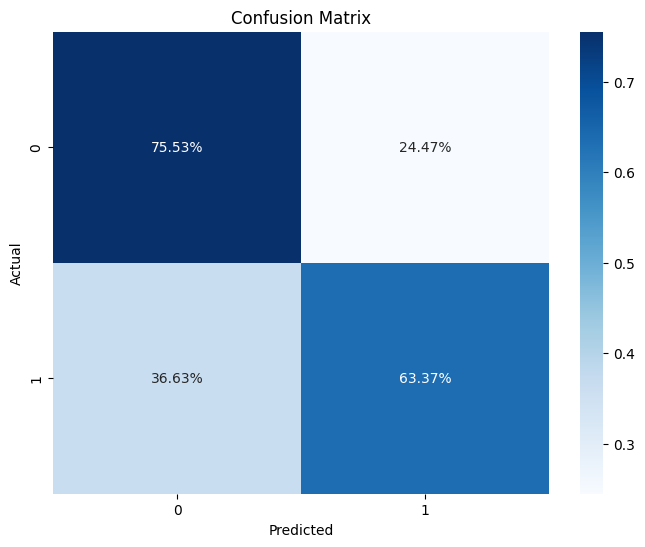

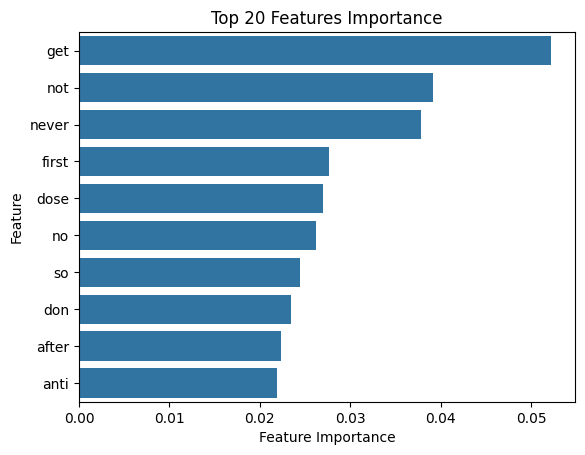

In [34]:
#Using a pipeline for efficiency and readability
pipeline_count=Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', GradientBoostingClassifier())
])

pipeline_count.fit(X_train, y_train)

# Training accuracy
scores = cross_val_score(pipeline_count, X_train, y_train)
print("Cross-validation accuracy :", scores.mean().round(3))

# Test accuracy
y_pred_count = pipeline_count.predict(X_test)
print("Test accuracy :", round(accuracy_score(y_test,y_pred_count),3))

# Classification report to evaluate the model
print(classification_report(y_test, y_pred_count,zero_division=1))

# Confusion matrix
conf_matrix_count = confusion_matrix(y_test, y_pred_count) / confusion_matrix(y_test, y_pred_count).sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_count, annot=True, fmt='.2%', cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Feature importance
feature_importance = pipeline_count.named_steps['classifier'].feature_importances_ # Get the importance
feature_names = pipeline_count.named_steps['vectorizer'].get_feature_names_out()   # Get feature names  
sorted_idx = feature_importance.argsort()[::-1][:10]  # Top 10 here

#Plotting
plt.figure()
sns.barplot(x=feature_importance[sorted_idx], y=np.array(feature_names)[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Features Importance')
plt.show()

Let's consider errors and observe why the model has made a mistake

In [35]:
# Let's print the comments where there is an error, lets say the first 5 errors
errors = np.where(y_test != y_pred_count)[0]
for i in range(5):
    print(X_test.iloc[errors[i]], "Real : ", y_test[errors[i]], "| Predicted : ", y_pred_count[errors[i]])
    

I heard over a radio call in that the vaccine has a permanent sterilization effect.  If so, would that be  permanent sterilization for this USA and worldwide.  If this is true what is the "ingredient" in the vaccine that would cause the sterilization???? Real :  0 | Predicted :  1
Okay, I'll have an immunity while y'all fucks are dying around me. Real :  1 | Predicted :  0
I don't vaccinate my kids. I believe its harmful to them and could lead to complications. I let my doctor do it, he's done it and studied how to for years. Real :  1 | Predicted :  0
I will take the vaccine because of solidarity reasons, i will do whats best for society as a whole. Real :  1 | Predicted :  0
This was very helpful, thank you! Real :  1 | Predicted :  0


1 - No real explanation 

2 - Because of "first in line" ?

3 - Because of "but" ? I don't know

4 - No idea

5 - The sentence is hard to understand, because of the "not very inclined"

Classification task with TF-IDF

Cross-validation accuracy : 0.676
Test accuracy : 0.697
              precision    recall  f1-score   support

           0       0.66      0.76      0.71        94
           1       0.74      0.64      0.69       101

    accuracy                           0.70       195
   macro avg       0.70      0.70      0.70       195
weighted avg       0.70      0.70      0.70       195



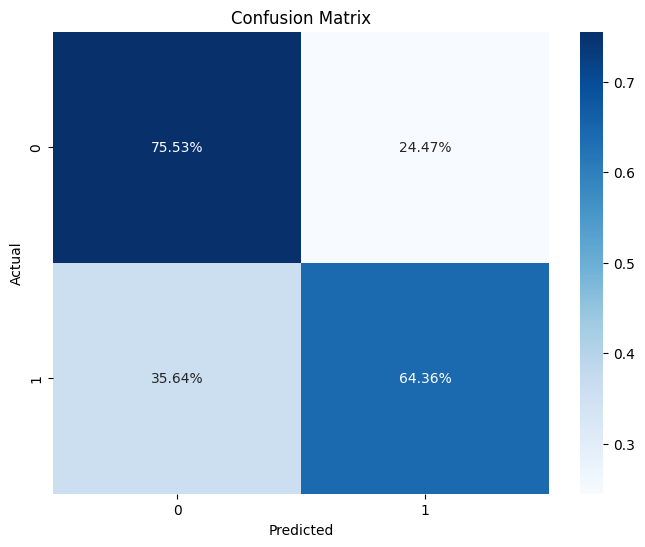

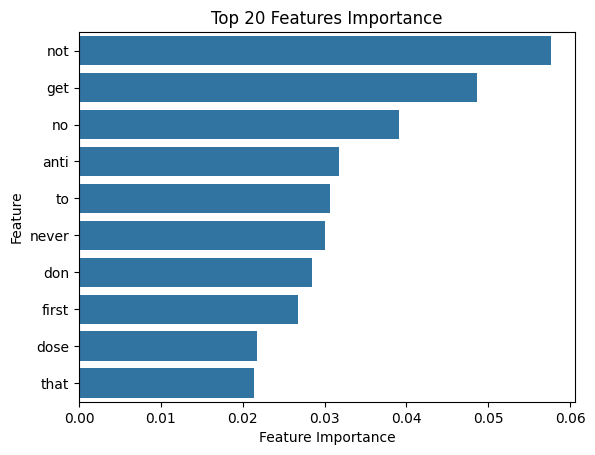

In [36]:
#Using a pipeline for efficiency and readability
pipeline_tf=Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', GradientBoostingClassifier())
])

pipeline_tf.fit(X_train, y_train)

# Training accuracy
scores = cross_val_score(pipeline_tf, X_train, y_train)
print("Cross-validation accuracy :", scores.mean().round(3))

# Test accuracy
y_pred_tf = pipeline_tf.predict(X_test)
print("Test accuracy :", round(accuracy_score(y_test,y_pred_tf),3))

# Classification report to evealuate the model
print(classification_report(y_test, y_pred_tf))

# Confusion matrix
conf_matrix_tf = confusion_matrix(y_test, y_pred_tf) / confusion_matrix(y_test, y_pred_tf).sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tf, annot=True, fmt='.2%', cmap="Blues", xticklabels=[0,1], yticklabels=sorted([0,1]))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature importance
feature_importance = pipeline_tf.named_steps['classifier'].feature_importances_ # Get the importance
feature_names = pipeline_tf.named_steps['vectorizer'].get_feature_names_out()   # Get feature names  
sorted_idx = feature_importance.argsort()[::-1][:10]  # Top 10 here

#Plotting
plt.figure()
sns.barplot(x=feature_importance[sorted_idx], y=np.array(feature_names)[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Features Importance')
plt.show()

Bag of words and TF-IDF are the same here. 

For both of them, it's easier to predict a positive comment than a negative one. This because of words like never or anti that are always associated with negative comments.

__Let's try another classifier : the perceptron__

The goal is to analyze if a linear model is fit for our dataset or not

Number of parameters in the perceptron :  16
Cross-validation accuracy : 0.724
Test accuracy : 0.697
              precision    recall  f1-score   support

           0       0.68      0.69      0.69        94
           1       0.71      0.70      0.71       101

    accuracy                           0.70       195
   macro avg       0.70      0.70      0.70       195
weighted avg       0.70      0.70      0.70       195



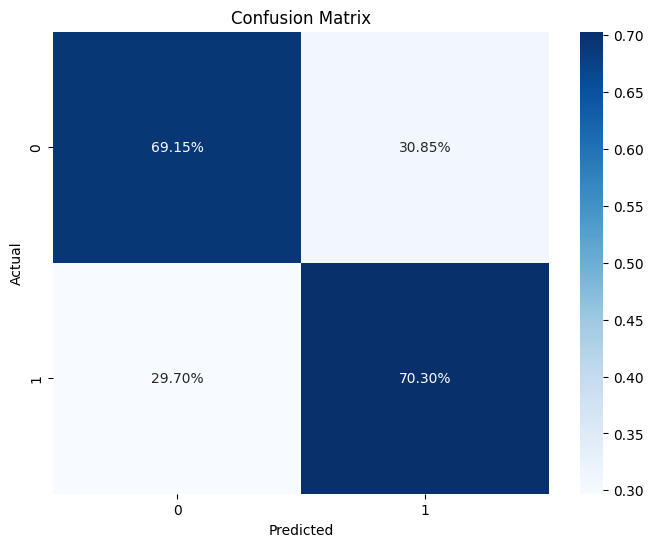

In [37]:
from sklearn.linear_model import Perceptron

x = Perceptron()

#count parameters in the perceptron
x.get_params()
# Print the number of params
print("Number of parameters in the perceptron : ", len(x.get_params()))


#Using a pipeline for efficiency and readability with a Perceptron classifier
pipeline_perceptron = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', Perceptron())
])

pipeline_perceptron.fit(X_train, y_train)

# Training accuracy
scores = cross_val_score(pipeline_perceptron, X_train, y_train)
print("Cross-validation accuracy :", scores.mean().round(3))

# Test accuracy
y_pred_perceptron = pipeline_perceptron.predict(X_test)
print("Test accuracy :", round(accuracy_score(y_test, y_pred_perceptron), 3))

# Classification report to evaluate the model
print(classification_report(y_test, y_pred_perceptron))

# Confusion matrix
conf_matrix_perceptron = confusion_matrix(y_test, y_pred_perceptron) / confusion_matrix(y_test, y_pred_perceptron).sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_perceptron, annot=True, fmt='.2%', cmap="Blues", xticklabels=[0, 1], yticklabels=sorted([0, 1]))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature importance is not available for Perceptron classifier as a linear model

Let's use bag of words and random forests

Cross-validation accuracy : 0.703
Test accuracy : 0.651
              precision    recall  f1-score   support

           0       0.62      0.73      0.67        94
           1       0.70      0.57      0.63       101

    accuracy                           0.65       195
   macro avg       0.66      0.65      0.65       195
weighted avg       0.66      0.65      0.65       195



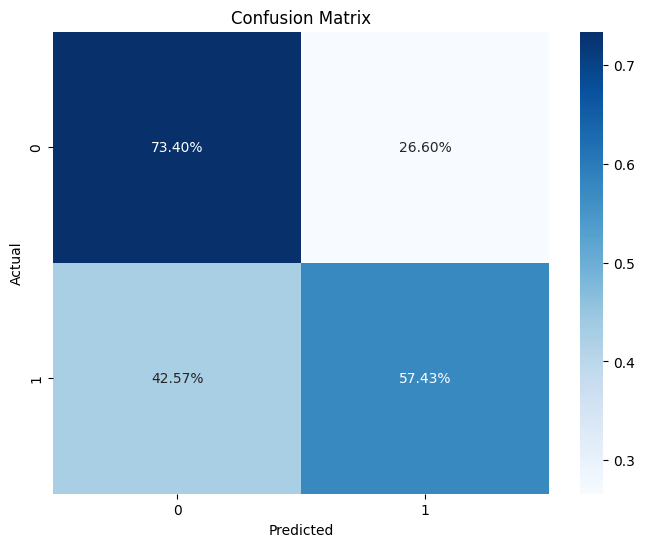

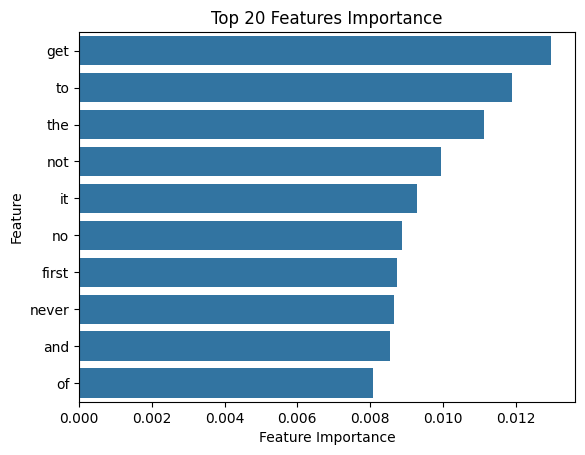

In [38]:
from sklearn.ensemble import RandomForestClassifier

# Using a pipeline for efficiency and readability with a Random Forest classifier
pipeline_random_forest = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', RandomForestClassifier())
])

pipeline_random_forest.fit(X_train, y_train)

# Training accuracy
scores = cross_val_score(pipeline_random_forest, X_train, y_train)
print("Cross-validation accuracy :", scores.mean().round(3))

# Test accuracy
y_pred_random_forest = pipeline_random_forest.predict(X_test)
print("Test accuracy :", round(accuracy_score(y_test, y_pred_random_forest), 3))

# Classification report to evaluate the model
print(classification_report(y_test, y_pred_random_forest))

# Confusion matrix
conf_matrix_random_forest = confusion_matrix(y_test, y_pred_random_forest) / confusion_matrix(y_test, y_pred_random_forest).sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_random_forest, annot=True, fmt='.2%', cmap="Blues", xticklabels=[0, 1], yticklabels=sorted([0, 1]))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature importance
feature_importance = pipeline_random_forest.named_steps['classifier'].feature_importances_ # Get the importance
feature_names = pipeline_random_forest.named_steps['vectorizer'].get_feature_names_out()   # Get feature names  
sorted_idx = feature_importance.argsort()[::-1][:10]  # Top 10 here

#Plotting
plt.figure()
sns.barplot(x=feature_importance[sorted_idx], y=np.array(feature_names)[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Features Importance')
plt.show()

Now, let's try to fine-tune it. For that, there is a very useful function call GridSearchSV that basically loops over values for some hyperparameters, and outputs the best values for our dataset.

In [39]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {
    'classifier__n_estimators': [10, 100, 200],
    'classifier__max_depth': [None,10,20],
    'classifier__min_samples_split': [2,5,10],
    'classifier__min_samples_leaf': [1,2,5]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline_random_forest, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model
best_model_scores = cross_val_score(best_model, X_train, y_train)
print("Best model cross-validation accuracy :", best_model_scores.mean().round(3))

# Test accuracy of the best model
y_pred_best_model = best_model.predict(X_test)
print("Best model test accuracy :", round(accuracy_score(y_test, y_pred_best_model), 3))

Best parameters: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
Best model cross-validation accuracy : 0.721
Best model test accuracy : 0.667


This fine-tuning barely changed the accuracy of the model. It might still be useful to repeat this process when using the larger dataset.

Let's use bag of words and SVC

Cross-validation accuracy : 0.724
Test accuracy : 0.687
              precision    recall  f1-score   support

           0       0.64      0.80      0.71        94
           1       0.76      0.58      0.66       101

    accuracy                           0.69       195
   macro avg       0.70      0.69      0.69       195
weighted avg       0.70      0.69      0.68       195



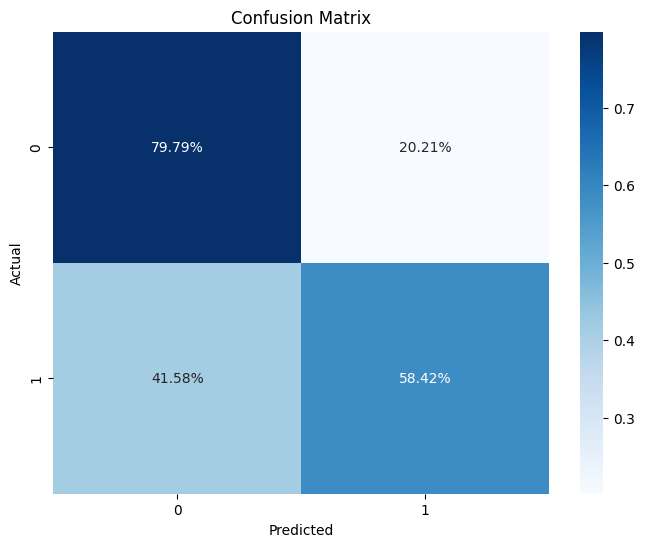

In [40]:
# Using a pipeline for efficiency and readability with a Random Forest classifier
pipeline_svc = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', SVC())
])

pipeline_svc.fit(X_train, y_train)

# Training accuracy
scores = cross_val_score(pipeline_svc, X_train, y_train)
print("Cross-validation accuracy :", scores.mean().round(3))

# Test accuracy
y_pred_svc = pipeline_svc.predict(X_test)
print("Test accuracy :", round(accuracy_score(y_test, y_pred_svc), 3))

# Classification report to evaluate the model
print(classification_report(y_test, y_pred_svc))

# Confusion matrix
conf_matrix_svc = confusion_matrix(y_test, y_pred_svc) / confusion_matrix(y_test, y_pred_svc).sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svc, annot=True, fmt='.2%', cmap="Blues", xticklabels=[0, 1], yticklabels=sorted([0, 1]))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Let's use BERT and random forests

Training accuracy : 0.983
Test accuracy : 0.692
              precision    recall  f1-score   support

           0       0.64      0.82      0.72        94
           1       0.77      0.57      0.66       101

    accuracy                           0.69       195
   macro avg       0.71      0.70      0.69       195
weighted avg       0.71      0.69      0.69       195



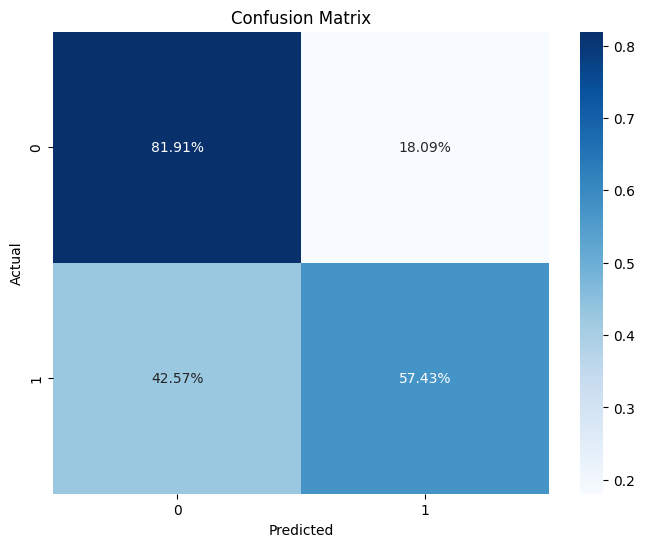

In [41]:
from transformers import AutoModel, BertTokenizerFast


# specify GPU
device = torch.device("cuda")

# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length = 25,
    padding = 'max_length',
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    X_test.tolist(),
    max_length = 25,
    padding ='max_length',
    truncation=True
)

# Move the BERT model to the specified device (GPU)
bert.to(device)

# Convert tokenized sequences to PyTorch tensors
train_input_ids = torch.tensor(tokens_train['input_ids']).to(device)
train_attention_mask = torch.tensor(tokens_train['attention_mask']).to(device)
test_input_ids = torch.tensor(tokens_test['input_ids']).to(device)
test_attention_mask = torch.tensor(tokens_test['attention_mask']).to(device)

# Forward pass the training set through BERT
with torch.no_grad():
    train_outputs = bert(input_ids=train_input_ids, attention_mask=train_attention_mask)

# Forward pass the test set through BERT
with torch.no_grad():
    test_outputs = bert(input_ids=test_input_ids, attention_mask=test_attention_mask)

# Extract the last hidden states from BERT output
train_embeddings = train_outputs.last_hidden_state
test_embeddings = test_outputs.last_hidden_state

# Convert the BERT embeddings to numpy arrays
train_embeddings_np = train_embeddings.cpu().numpy()
test_embeddings_np = test_embeddings.cpu().numpy()

# Flatten the BERT embeddings
train_embeddings_flattened = train_embeddings_np.reshape(train_embeddings_np.shape[0], -1)
test_embeddings_flattened = test_embeddings_np.reshape(test_embeddings_np.shape[0], -1)

# Fit a Random Forest classifier on top of flattened BERT embeddings
random_forest_bert = SVC()
random_forest_bert.fit(train_embeddings_flattened, y_train)

# Training accuracy
train_accuracy = random_forest_bert.score(train_embeddings_flattened, y_train)
print("Training accuracy :", round(train_accuracy,3))

# Test accuracy
test_accuracy = random_forest_bert.score(test_embeddings_flattened, y_test)
print("Test accuracy :", round(test_accuracy,3))

# Classification report to evaluate the model
y_pred_random_forest_bert = random_forest_bert.predict(test_embeddings_flattened)
print(classification_report(y_test, y_pred_random_forest_bert))

# Confusion matrix
conf_matrix_random_forest_bert = confusion_matrix(y_test, y_pred_random_forest_bert) / confusion_matrix(y_test, y_pred_random_forest_bert).sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_random_forest_bert, annot=True, fmt='.2%', cmap="Blues", xticklabels=[0, 1], yticklabels=sorted([0, 1]))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

BERT is not really efficient here, as there is an overfitting on the training data.

__2 - Doing the classification for the actual dataset__

There will be a lot to think about here : 

- What to do when there's more than 2 annotations ?
- What to do when the annotators disagree ? Should we remove the line ?
- What to do when there's a -1 ? Remove the line too ? 

In [42]:
# Get the data
big_dataset = pd.read_csv('a3_train_final.tsv', sep='\t', header=None,names=['labels', 'comments'])
X = big_dataset['comments']

# Explore label distribution to see if the dataset is balanced
label_distribution = big_dataset['labels'].value_counts(normalize=True)
print(label_distribution)

labels_split = [(x.split('/')) for x in big_dataset['labels'] if len(x.split('/')) >= 1]
# if there is a -1 inside each of the list, delete the list
labels_split_cut = [x for x in labels_split if '-1' not in x]
print(len(labels_split_cut)/len(labels_split)*100)

labels
1/1                            0.384437
0/0                            0.363925
0/-1                           0.048614
1/-1                           0.041583
1/0                            0.029300
                                 ...   
0/1/0/0/0                      0.000020
0/0/1/-1                       0.000020
1/1/1/1/1/1/1/1/1/0/1/1/1/1    0.000020
0/1/0/1/1/0/0/1                0.000020
1/0/-1/-1                      0.000020
Name: proportion, Length: 190, dtype: float64
90.24326915395062
90.24326915395062


We see that around 75% of the dataset is made of 0/0 and 1/1. 

We could just get those but let's do a majority vote :
- We take the number that is the most represented in all the votes. 
- If there is a majoritary number of -1, we remove the line
- If there is an equal number of 0 and 1, we remove the line

In [43]:
from collections import Counter

# Let's get each line of labels and split them
labels_split = [(x.split('/')) for x in big_dataset['labels'] if len(x.split('/')) >= 1]
Y = []

rows_to_drop = []  # Collect the indices of rows to drop

for k, labels in enumerate(labels_split):
    counts = Counter(labels)
    majority_element, majority_count = counts.most_common(1)[0]
    
    if majority_element == '-1':
        rows_to_drop.append(k)  # Remove the comment
        
    elif majority_count > len(labels) / 2:
        Y.append(int(majority_element))
        
    else:
        rows_to_drop.append(k) # Remove the comment if there is an equal number of labels

# Remove the rows from X
X_cleaned = X.drop(rows_to_drop)

# Get label distribution
label_distribution = Counter(Y)
label_distribution_normalized = {key: value / len(Y) for key, value in label_distribution.items()}

# Print while rounding to 3 decimal places
print({key: round(value, 3) for key, value in label_distribution_normalized.items()})

print(len(big_dataset) - len(rows_to_drop))
# Check how much data we lost by removing the rows
print("Percentage of data removed :", round(len(rows_to_drop) / len(big_dataset) * 100, 3), "%")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, Y, test_size=0.2, shuffle=True)

{1: 0.51, 0: 0.49}
42792
Percentage of data removed : 14.532 %


As we see, with all this sorting, we lost 15 % of data.
If we just kept 1/1 and 0/0, we would have lost 25 % of it. Thus it's a great improvement.

Now, let's try BERT + SVC

In [44]:
"""
import torch
from transformers import AutoModel, BertTokenizerFast
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# specify GPU
device = torch.device("cuda")

# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

#Move it to the GPU
bert.to(device)

# Function to tokenize and encode sequences in batches
def encode_sequences(tokenizer, sequences, max_length):
    encoded_seqs = []
    for i in range(0, len(sequences), 100):  # Process in batches of 100
        batch_seqs = sequences[i:i+100]
        tokens_batch = tokenizer(batch_seqs, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
        tokens_batch = {k: v.to(device) for k, v in tokens_batch.items()}  # Move tensors to GPU
        with torch.no_grad():
            outputs = bert(**tokens_batch)
        last_hidden_states = outputs.last_hidden_state
        encoded_seqs.append(last_hidden_states.cpu().numpy())  # Move tensors back to CPU and append
        del tokens_batch, outputs, last_hidden_states  # Free memory
        torch.cuda.empty_cache()  # Empty cache to free up memory
    return np.vstack(encoded_seqs).astype(np.float32)  # Ensure dtype is float32

# Tokenize and encode sequences 
train_embeddings = encode_sequences(tokenizer, X_train.tolist(), max_length=25)
test_embeddings = encode_sequences(tokenizer, X_test.tolist(), max_length=25)

# Get the dimensions of the embeddings
num_train_samples, seq_length, embedding_dim = train_embeddings.shape
num_test_samples = test_embeddings.shape[0]

# Flatten them
train_embeddings_flattened = train_embeddings.reshape(num_train_samples, -1)
test_embeddings_flattened = test_embeddings.reshape(num_test_samples, -1)

# Fit a Support Vector Classifier on top of flattened BERT embeddings
random_forest_bert = SVC()
random_forest_bert.fit(train_embeddings_flattened, y_train)

# Training accuracy
train_accuracy = random_forest_bert.score(train_embeddings_flattened, y_train)
print("Training accuracy :", round(train_accuracy, 3))

# Test accuracy
test_accuracy = random_forest_bert.score(test_embeddings_flattened, y_test)
print("Test accuracy :", round(test_accuracy, 3))

# Classification report to evaluate the model
y_pred_random_forest_bert = random_forest_bert.predict(test_embeddings_flattened)
print(classification_report(y_test, y_pred_random_forest_bert))

# Confusion matrix
conf_matrix_random_forest_bert = confusion_matrix(y_test, y_pred_random_forest_bert) / confusion_matrix(y_test, y_pred_random_forest_bert).sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_random_forest_bert, annot=True, fmt='.2%', cmap="Blues", xticklabels=[0, 1], yticklabels=sorted([0, 1]))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
"""

'\nimport torch\nfrom transformers import AutoModel, BertTokenizerFast\nfrom sklearn.svm import SVC\nfrom sklearn.metrics import classification_report, confusion_matrix\nimport seaborn as sns\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n# specify GPU\ndevice = torch.device("cuda")\n\n# import BERT-base pretrained model\nbert = AutoModel.from_pretrained(\'bert-base-uncased\')\n\n# Load the BERT tokenizer\ntokenizer = BertTokenizerFast.from_pretrained(\'bert-base-uncased\')\n\n#Move it to the GPU\nbert.to(device)\n\n# Function to tokenize and encode sequences in batches\ndef encode_sequences(tokenizer, sequences, max_length):\n    encoded_seqs = []\n    for i in range(0, len(sequences), 100):  # Process in batches of 100\n        batch_seqs = sequences[i:i+100]\n        tokens_batch = tokenizer(batch_seqs, padding=\'max_length\', truncation=True, max_length=max_length, return_tensors=\'pt\')\n        tokens_batch = {k: v.to(device) for k, v in tokens_batch.items()}  # Move ten

Cross-validation accuracy : 0.823
Test accuracy : 0.834
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      4203
           1       0.83      0.84      0.84      4356

    accuracy                           0.83      8559
   macro avg       0.83      0.83      0.83      8559
weighted avg       0.83      0.83      0.83      8559



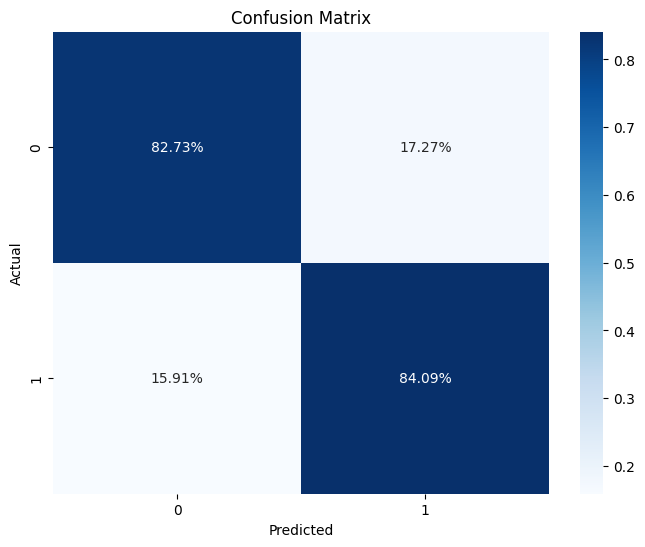

In [45]:
# Using a pipeline for efficiency and readability with SVC
pipeline_svc = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', SVC())
])

pipeline_svc.fit(X_train, y_train)

# Training accuracy
scores = cross_val_score(pipeline_svc, X_train, y_train)
print("Cross-validation accuracy :", scores.mean().round(3))

# Test accuracy
y_pred_svc = pipeline_svc.predict(X_test)
print("Test accuracy :", round(accuracy_score(y_test, y_pred_svc), 3))

# Classification report to evaluate the model
print(classification_report(y_test, y_pred_svc))

# Confusion matrix
conf_matrix_svc = confusion_matrix(y_test, y_pred_svc) / confusion_matrix(y_test, y_pred_svc).sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svc, annot=True, fmt='.2%', cmap="Blues", xticklabels=[0, 1], yticklabels=sorted([0, 1]))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Test accuracy : 0.852
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1020
           1       0.86      0.84      0.85      1019

    accuracy                           0.85      2039
   macro avg       0.85      0.85      0.85      2039
weighted avg       0.85      0.85      0.85      2039



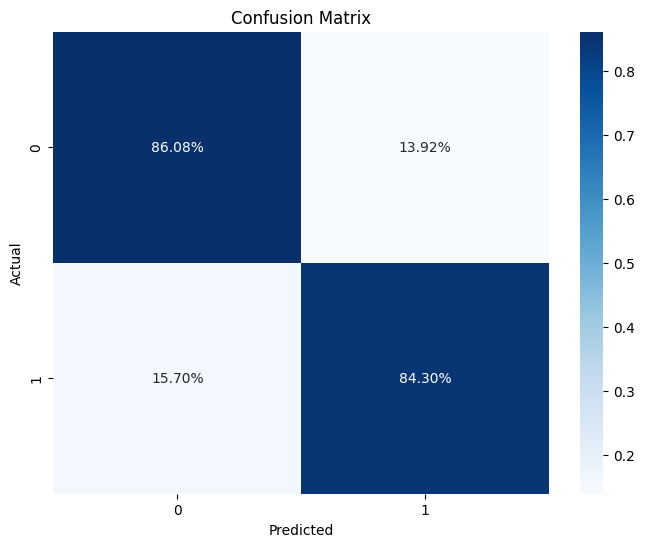

Don't tell me what to do with my body - the same people that want to enforce anti-abortion laws on women. Real :  1 | Predicted :  0
I don't know what's in it. As if they know what's in the hamburgers they eat, the milk they drink, the high fructose corn syrup they consume... what a tragedy of stupidity. Real :  1 | Predicted :  0
I trust my immune system just translates to "I don't know how vaccines work." Real :  1 | Predicted :  0
Vaccines are saving lives meanwhile romania being the least vaccinated and also least infected country in the whole europe Real :  0 | Predicted :  1
We take other risks so taking this one shouldnt be a problem is the dumbest argument there is... Real :  0 | Predicted :  1


In [46]:
# Test pipeline svc on the test set
# Get the data
dataset_test = pd.read_csv('a3_test.tsv', sep='\t', header=None,names=['labels', 'comments'])

# From txt to int if x is different than -1
y_test =[int(x) for x in dataset_test['labels']]
X_test = dataset_test['comments']

y_pred_svc = pipeline_svc.predict(X_test)

# Compute the test-set score
test_accuracy = accuracy_score(y_test, y_pred_svc)
print("Test accuracy :", round(test_accuracy, 3))

# Classification report to evaluate the model
print(classification_report(y_test, y_pred_svc))

# Confusion matrix
conf_matrix_svc = confusion_matrix(y_test, y_pred_svc) / confusion_matrix(y_test, y_pred_svc).sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svc, annot=True, fmt='.2%', cmap="Blues", xticklabels=[0, 1], yticklabels=sorted([0, 1]))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Let's print the comments where there is an error, lets say the first 5 errors
errors = np.where(y_test != y_pred_svc)[0]
for i in range(5):
    print(X_test.iloc[errors[i]], "Real : ", y_test[errors[i]], "| Predicted : ", y_pred_svc[errors[i]])

Most of the errors are due to comments being mislabeled !!
The second one "I trust my immune system just translates to "I don't know how vaccines work." " is tricky.

We could try another method of voting, like only taking the one that are always labeled the same. We'll lost data but maybe it will be worth it.

{1: 0.51, 0: 0.49}
Percentage of data removed : 15.621 %
Cross-validation accuracy : 0.822
Test accuracy : 0.831
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      4159
           1       0.84      0.82      0.83      4291

    accuracy                           0.83      8450
   macro avg       0.83      0.83      0.83      8450
weighted avg       0.83      0.83      0.83      8450



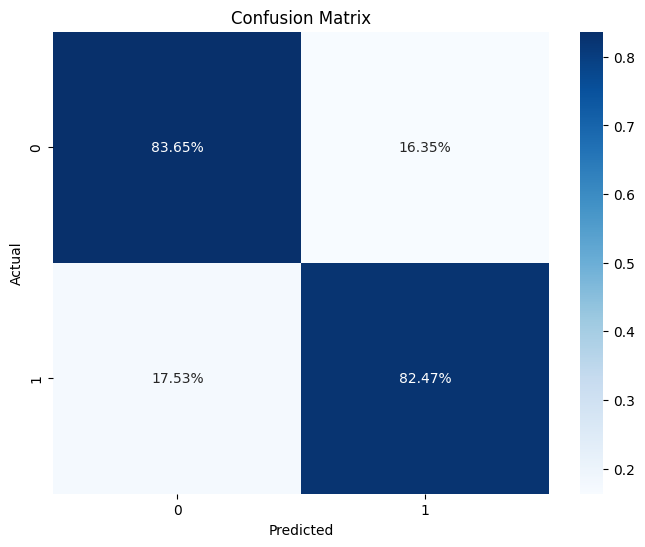

Test accuracy : 0.847
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1020
           1       0.86      0.83      0.84      1019

    accuracy                           0.85      2039
   macro avg       0.85      0.85      0.85      2039
weighted avg       0.85      0.85      0.85      2039



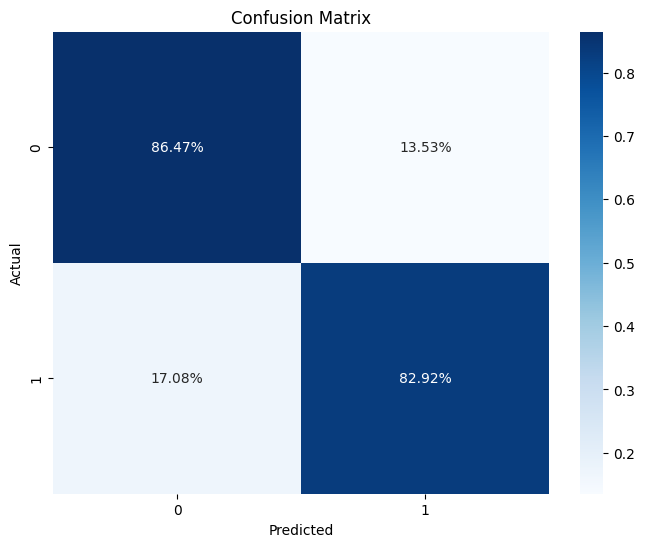

Don't tell me what to do with my body - the same people that want to enforce anti-abortion laws on women. Real :  1 | Predicted :  0
I don't know what's in it. As if they know what's in the hamburgers they eat, the milk they drink, the high fructose corn syrup they consume... what a tragedy of stupidity. Real :  1 | Predicted :  0
I trust my immune system just translates to "I don't know how vaccines work." Real :  1 | Predicted :  0
Vaccines are saving lives meanwhile romania being the least vaccinated and also least infected country in the whole europe Real :  0 | Predicted :  1
We take other risks so taking this one shouldnt be a problem is the dumbest argument there is... Real :  0 | Predicted :  1


In [50]:
Y2 = []

rows_to_drop = []  # Collect the indices of rows to drop


for k, labels in enumerate(labels_split):
    # If the list is not made of only zeros or only ones, we remove the comment

    if labels.count('0') != len(labels) and labels.count('1') != len(labels):
        rows_to_drop.append(k)
    else:
        Y2.append(int(labels[0]))
    
# Remove the rows from X
X_cleaned2 = X.drop(rows_to_drop)

# Get label distribution
label_distribution = Counter(Y2)
label_distribution_normalized = {key: value / len(Y2) for key, value in label_distribution.items()}

# Print while rounding to 3 decimal places
print({key: round(value, 3) for key, value in label_distribution_normalized.items()})

# Check how much data we lost by removing the rows
print("Percentage of data removed :", round(len(rows_to_drop) / len(big_dataset) * 100, 3), "%")

# Split the data
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_cleaned2, Y2, test_size=0.2, shuffle=True)

# Using a pipeline for efficiency and readability with SVC
pipeline_svc2 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', SVC())
])

pipeline_svc2.fit(X_train2, y_train2)

# Training accuracy
scores2 = cross_val_score(pipeline_svc2, X_train2, y_train2)
print("Cross-validation accuracy :", scores2.mean().round(3))

# Test accuracy
y_pred_svc2 = pipeline_svc2.predict(X_test2)
print("Test accuracy :", round(accuracy_score(y_test2, y_pred_svc2), 3))

# Classification report to evaluate the model
print(classification_report(y_test2, y_pred_svc2))

# Confusion matrix
conf_matrix_svc2 = confusion_matrix(y_test2, y_pred_svc2) / confusion_matrix(y_test2, y_pred_svc2).sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svc2, annot=True, fmt='.2%', cmap="Blues", xticklabels=[0, 1], yticklabels=sorted([0, 1]))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Test pipeline svc on the test set
# Get the data
dataset_test = pd.read_csv('a3_test.tsv', sep='\t', header=None,names=['labels', 'comments'])

# From txt to int if x is different than -1
y_test_test =[int(x) for x in dataset_test['labels']]
X_test_test = dataset_test['comments']

y_pred_svc_test = pipeline_svc2.predict(X_test_test)

# Compute the test-set score
test_accuracy = accuracy_score(y_test_test, y_pred_svc_test)
print("Test accuracy :", round(test_accuracy, 3))

# Classification report to evaluate the model
print(classification_report(y_test_test, y_pred_svc_test))

# Confusion matrix
conf_matrix_svc = confusion_matrix(y_test_test, y_pred_svc_test) / confusion_matrix(y_test_test, y_pred_svc_test).sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svc, annot=True, fmt='.2%', cmap="Blues", xticklabels=[0, 1], yticklabels=sorted([0, 1]))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Let's print the comments where there is an error, lets say the first 5 errors
errors = np.where(y_test_test != y_pred_svc_test)[0]
for i in range(5):
    print(X_test_test.iloc[errors[i]], "Real : ", y_test_test[errors[i]], "| Predicted : ", y_pred_svc_test[errors[i]])


Most comments that are not well predicted are tricky. Let's use TF-IDF and see

{1: 0.51, 0: 0.49}
Percentage of data removed : 15.621 %
Cross-validation accuracy : 0.848
Test accuracy : 0.855
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      4199
           1       0.85      0.86      0.86      4251

    accuracy                           0.85      8450
   macro avg       0.85      0.85      0.85      8450
weighted avg       0.85      0.85      0.85      8450



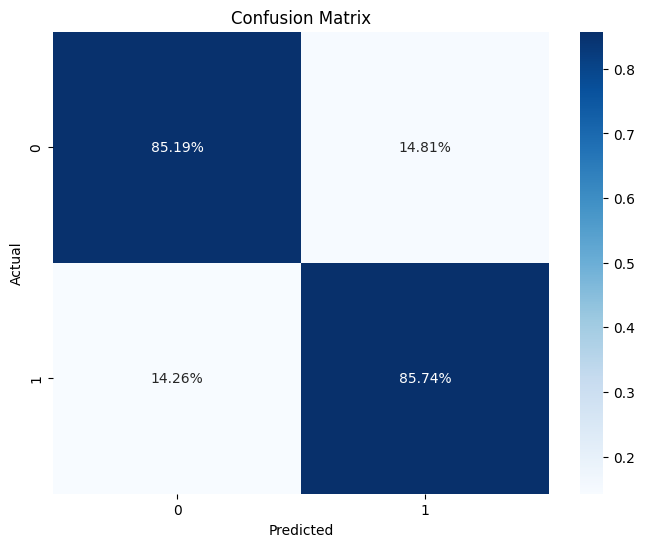

Test accuracy : 0.869
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1020
           1       0.88      0.86      0.87      1019

    accuracy                           0.87      2039
   macro avg       0.87      0.87      0.87      2039
weighted avg       0.87      0.87      0.87      2039



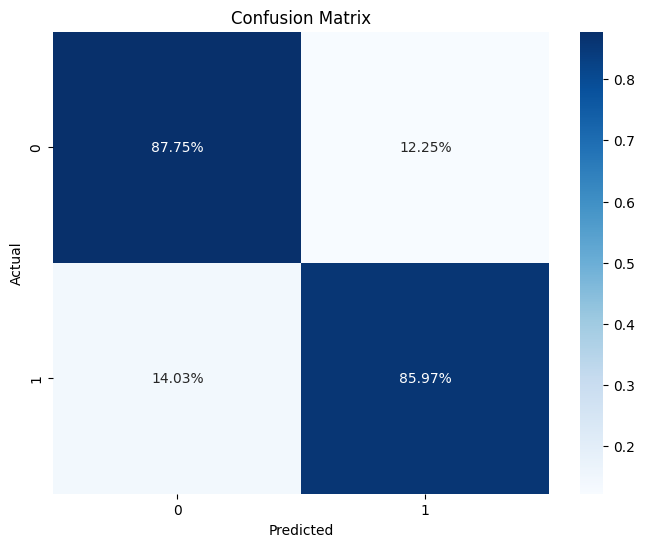

Don't tell me what to do with my body - the same people that want to enforce anti-abortion laws on women. Real :  1 | Predicted :  0
I did my own research means you looked online at what you already believed in, and then the algorithm kept feeding you your own opinion, making you believe you are right. Instead of believing the actual scientific research or doctors who actually studied this. Also the "I knew someone who had a bad reaction" is not a reason. Not if you simply ignore the millions of people who had no bad reaction. Real :  1 | Predicted :  0
I don't know what's in it. As if they know what's in the hamburgers they eat, the milk they drink, the high fructose corn syrup they consume... what a tragedy of stupidity. Real :  1 | Predicted :  0
I trust my immune system just translates to "I don't know how vaccines work." Real :  1 | Predicted :  0
Vaccines are saving lives meanwhile romania being the least vaccinated and also least infected country in the whole europe Real :  0 | 

In [51]:
Y3 = []

rows_to_drop = []  # Collect the indices of rows to drop

for k, labels in enumerate(labels_split):
    # If the list is not made of only zeros or only ones, we remove the comment
    if labels.count('0') != len(labels) and labels.count('1') != len(labels):
        rows_to_drop.append(k)
    else:
        Y3.append(int(labels[0]))
    
# Remove the rows from X
X_cleaned3 = X.drop(rows_to_drop)

# Get label distribution
label_distribution = Counter(Y3)
label_distribution_normalized = {key: value / len(Y3) for key, value in label_distribution.items()}

# Print while rounding to 3 decimal places
print({key: round(value, 3) for key, value in label_distribution_normalized.items()})

# Check how much data we lost by removing the rows
print("Percentage of data removed :", round(len(rows_to_drop) / len(big_dataset) * 100, 3), "%")

# Split the data
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_cleaned3, Y3, test_size=0.2, shuffle=True)

# Using a pipeline for efficiency and readability with SVC
pipeline_svc3 = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', SVC())
])

pipeline_svc3.fit(X_train3, y_train3)

# Training accuracy
scores3 = cross_val_score(pipeline_svc3, X_train3, y_train3)
print("Cross-validation accuracy :", scores3.mean().round(3))

# Test accuracy
y_pred_svc3 = pipeline_svc3.predict(X_test3)
print("Test accuracy :", round(accuracy_score(y_test3, y_pred_svc3), 3))

# Classification report to evaluate the model
print(classification_report(y_test3, y_pred_svc3))

# Confusion matrix
conf_matrix_svc = confusion_matrix(y_test3, y_pred_svc3) / confusion_matrix(y_test3, y_pred_svc3).sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svc, annot=True, fmt='.2%', cmap="Blues", xticklabels=[0, 1], yticklabels=sorted([0, 1]))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


y_pred_svc_test2 = pipeline_svc3.predict(X_test_test)

# Compute the test-set score
test_accuracy = accuracy_score(y_test_test, y_pred_svc_test2)
print("Test accuracy :", round(test_accuracy, 3))

# Classification report to evaluate the model
print(classification_report(y_test_test, y_pred_svc_test2))

# Confusion matrix
conf_matrix_svc3 = confusion_matrix(y_test_test, y_pred_svc_test2) / confusion_matrix(y_test_test, y_pred_svc_test2).sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svc3, annot=True, fmt='.2%', cmap="Blues", xticklabels=[0, 1], yticklabels=sorted([0, 1]))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Let's print the comments where there is an error, lets say the first 5 errors
errors = np.where(y_test_test != y_pred_svc_test2)[0]
for i in range(5):
    print(X_test_test.iloc[errors[i]], "Real : ", y_test_test[errors[i]], "| Predicted : ", y_pred_svc_test2[errors[i]])


Cross-validation accuracy : 0.512
Test accuracy : 0.503
              precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       1.00      0.50      0.67      8450

    accuracy                           0.50      8450
   macro avg       0.50      0.75      0.33      8450
weighted avg       1.00      0.50      0.67      8450



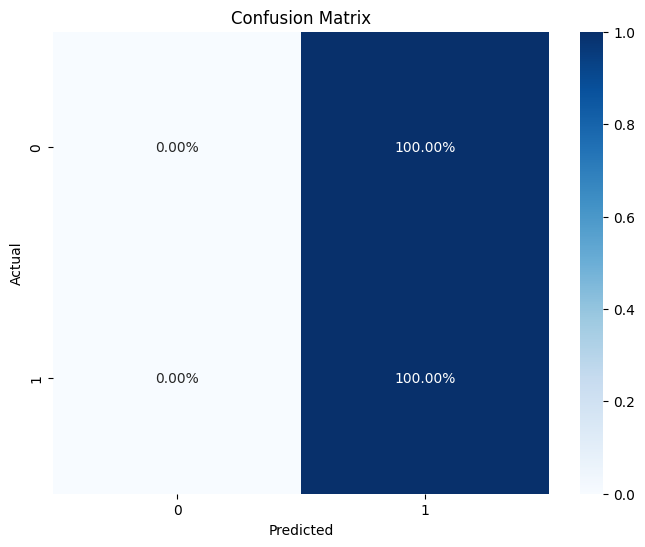

[1 1 1 ... 1 1 1]
Test accuracy : 0.5
              precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       1.00      0.50      0.67      2039

    accuracy                           0.50      2039
   macro avg       0.50      0.75      0.33      2039
weighted avg       1.00      0.50      0.67      2039



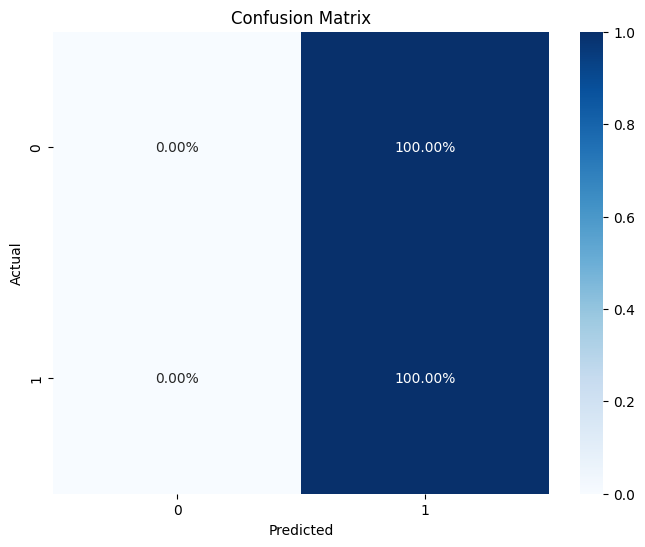

[1 1 1 ... 1 1 1]


In [ ]:
# code the same thing but the classifier is a majority class baseline
from sklearn.dummy import DummyClassifier

# Using a pipeline for efficiency and readability with SVC
pipeline_dummy = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', DummyClassifier(strategy='most_frequent'))
])

pipeline_dummy.fit(X_train, y_train)

# Training accuracy
scores = cross_val_score(pipeline_dummy, X_train, y_train)
print("Cross-validation accuracy :", scores.mean().round(3))

# Test accuracy
y_pred_dummy = pipeline_dummy.predict(X_test)
print("Test accuracy :", round(accuracy_score(y_test, y_pred_dummy), 3))

# Classification report to evaluate the model
print(classification_report(y_pred_dummy, y_test,zero_division=1))

# Confusion matrix
conf_matrix_dummy = confusion_matrix(y_test, y_pred_dummy) / confusion_matrix(y_test, y_pred_dummy).sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dummy, annot=True, fmt='.2%', cmap="Blues", xticklabels=[0, 1], yticklabels=sorted([0, 1]))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(y_pred_dummy)

# Get the data
dataset_test = pd.read_csv('a3_test.tsv', sep='\t', header=None,names=['labels', 'comments'])

# From txt to int if x is different than -1
y_test_test =[int(x) for x in dataset_test['labels']]
X_test_test = dataset_test['comments']

y_pred_test_dummy = pipeline_dummy.predict(X_test_test)

# Compute the test-set score
test_accuracy = accuracy_score(y_test_test, y_pred_test_dummy)
print("Test accuracy :", round(test_accuracy, 3))

# Classification report to evaluate the model
print(classification_report( y_pred_test_dummy,y_test_test,zero_division=1  ))

# Confusion matrix
conf_matrix_dummy = confusion_matrix(y_test_test, y_pred_test_dummy) / confusion_matrix(y_test_test, y_pred_test_dummy).sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dummy, annot=True, fmt='.2%', cmap="Blues", xticklabels=[0, 1], yticklabels=sorted([0, 1]))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
    
print(y_pred_test_dummy)